# Group ID 5
#    - 24280064 Arslan Rafiq
#    - 24280040 Talha Nasir


# Imports and Setup

In [ ]:
import os
import glob
import re
import random
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Use the frames directory produced earlier.
# If the previous cell defined 'output_dir', prefer it; otherwise, fall back to a default.
frames_dir = r"C:\Users\ASUS\Desktop\PROJECT\CV\data\frames"
try:
    if 'output_dir' in globals() and output_dir:
        frames_dir = output_dir
except NameError:
    pass

# Natural sort for file names (e.g., frame_2 < frame_10)
def _natural_key(s):
    return [int(t) if t.isdigit() else t.lower() for t in re.split(r'(\d+)', s)]

# Load all extracted frame paths and sort
image_paths = glob.glob(os.path.join(frames_dir, '*.jpg')) + \
               glob.glob(os.path.join(frames_dir, '*.png'))
image_paths = sorted(image_paths, key=_natural_key)

print(f"Found {len(image_paths)} extracted frames in '{frames_dir}'")


Found 285 extracted frames in 'C:\Users\ASUS\Desktop\PROJECT\CV\data\frames'


# Random Sample Grid

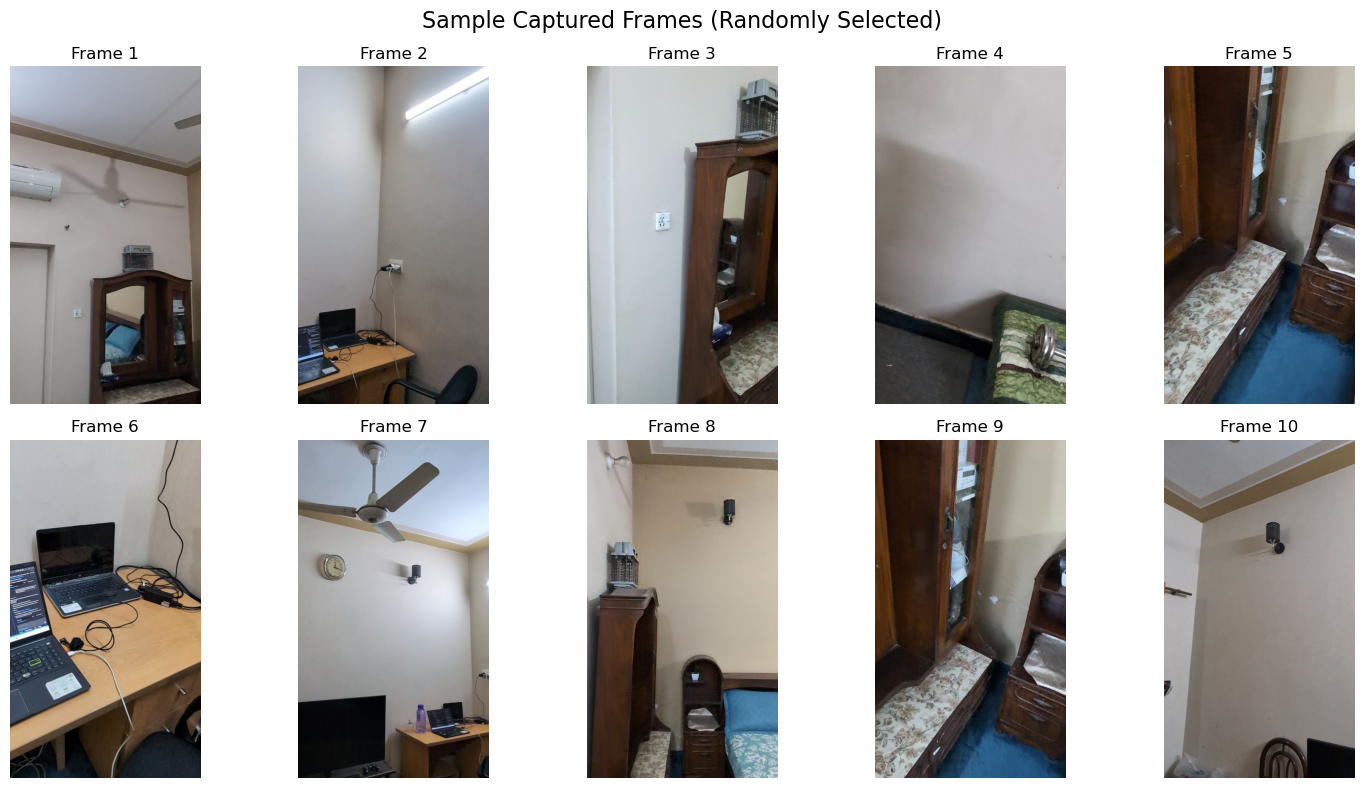

In [ ]:
# Randomly choose up to 10 frames and displays in a 2x5 grid.

assert len(image_paths) > 0, "No frames found. Ensure 'frames_dir' points to your frames folder."
sample_size = min(10, len(image_paths))
sample_paths = random.sample(image_paths, sample_size)

cols = 5
rows = 2 if sample_size > 5 else 1
plt.figure(figsize=(15, 8))
for i, p in enumerate(sample_paths[: rows * cols]):
    img_bgr = cv2.imread(p)
    if img_bgr is None:
        continue
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    plt.subplot(rows, cols, i + 1)
    plt.imshow(img_rgb)
    plt.title(f"Frame {i + 1}")
    plt.axis('off')
plt.suptitle('Sample Captured Frames (Randomly Selected)', fontsize=16)
plt.tight_layout()
plt.show()


# Preprocessing

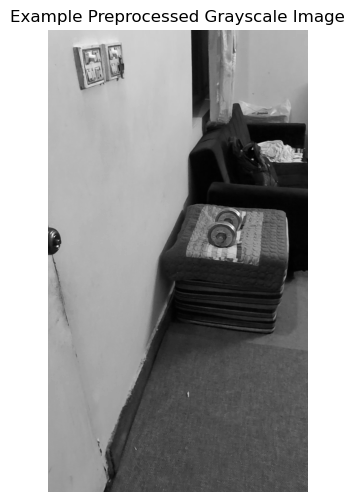

In [ ]:
def preprocess_image(img_path, scale=0.5):
    img = cv2.imread(img_path)
    if img is None:
        raise FileNotFoundError(f"Could not read image: {img_path}")
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    if scale and scale != 1.0:
        h, w = gray.shape[:2]
        new_w = max(1, int(w * scale))
        new_h = max(1, int(h * scale))
        gray = cv2.resize(gray, (new_w, new_h), interpolation=cv2.INTER_AREA)
    return gray

# Displaying one example preprocessed image
example_path = image_paths[0]
example_gray = preprocess_image(example_path, scale=0.5)
plt.figure(figsize=(6, 6))
plt.imshow(example_gray, cmap='gray')
plt.title('Example Preprocessed Grayscale Image')
plt.axis('off')
plt.show()


# SIFT Feature Matching Helper

In [ ]:
# Feature Detection and Matching (SIFT + BFMatcher with Lowe's ratio test)
# Returns keypoints from both images and the list of good matches.

def _create_sift():
    # Try modern API first; fallback to xfeatures2d if needed.
    if hasattr(cv2, 'SIFT_create'):
        return cv2.SIFT_create()
    if hasattr(cv2, 'xfeatures2d') and hasattr(cv2.xfeatures2d, 'SIFT_create'):
        return cv2.xfeatures2d.SIFT_create()
    raise RuntimeError('SIFT is unavailable. Install opencv-contrib-python.')

def match_features(img1_gray, img2_gray, ratio_thresh=0.75):
    """
    Detects SIFT keypoints/descriptors in two grayscale images,
    matches them with BFMatcher (L2), and applies Lowe's ratio test.
    Returns (kp1, kp2, good_matches).
    """
    sift = _create_sift()
    # Detect keypoints and compute descriptors
    kp1, des1 = sift.detectAndCompute(img1_gray, None)
    kp2, des2 = sift.detectAndCompute(img2_gray, None)

    if des1 is None or des2 is None or len(des1) == 0 or len(des2) == 0:
        return kp1 or [], kp2 or [], []

    # Brute-force matcher with L2 norm for SIFT
    bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=False)
    knn = bf.knnMatch(des1, des2, k=2)

    # Lowe's ratio test to keep good matches
    good = []
    for m, n in knn:
        if m.distance < ratio_thresh * n.distance:
            good.append(m)

    # Sort by distance (best first)
    good.sort(key=lambda x: x.distance)
    return kp1, kp2, good


# Matching Across Consecutive Frames

Pair 0-1: good matches = 400


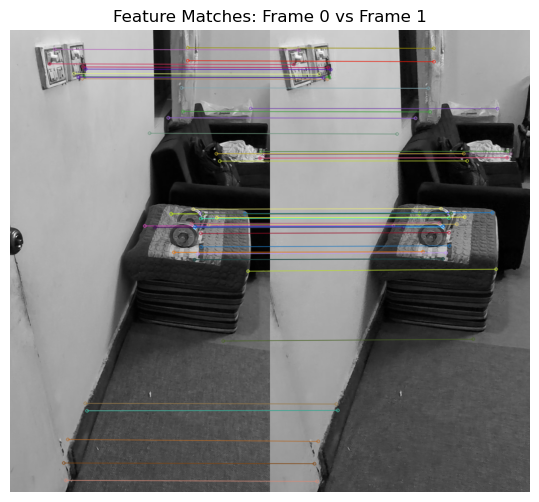

Pair 1-2: good matches = 247


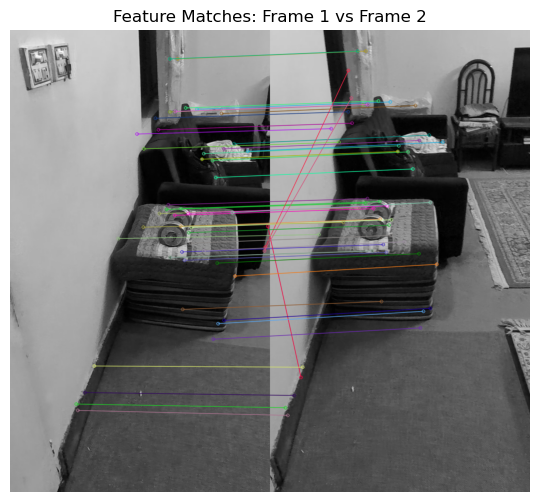

Pair 2-3: good matches = 375


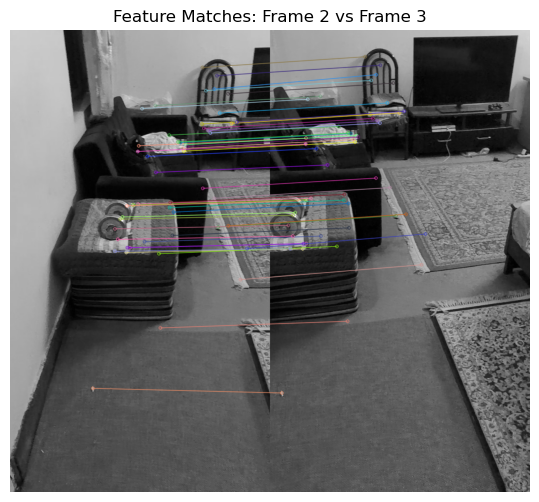

Pair 3-4: good matches = 959


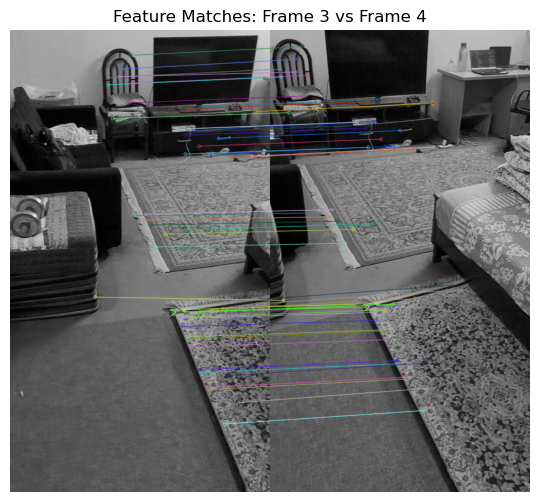

Pair 4-5: good matches = 1939


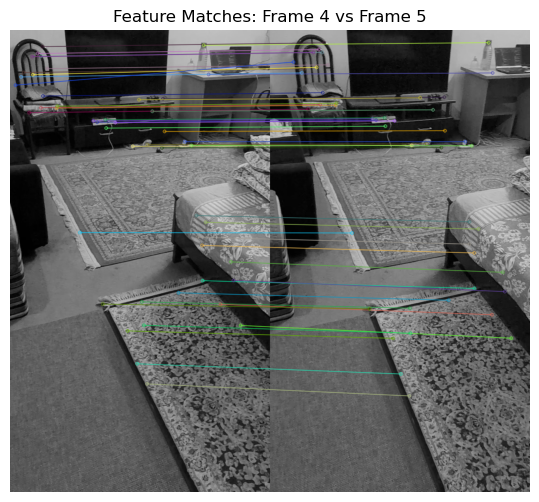

In [ ]:
# Feature Matching Visualization Across Consecutive Frames (for 5 consecutive pairs)

assert len(image_paths) >= 2, 'Need at least two frames to match.'
num_pairs = min(5, len(image_paths) - 1)
start_idx = 0
pairs = [(i, i + 1) for i in range(start_idx, start_idx + num_pairs)]

example_match_vis_bgr = None
for idx, (i, j) in enumerate(pairs, start=1):
    img1_gray = preprocess_image(image_paths[i], scale=0.5)
    img2_gray = preprocess_image(image_paths[j], scale=0.5)

    kp1, kp2, good = match_features(img1_gray, img2_gray, ratio_thresh=0.75)
    print(f"Pair {i}-{j}: good matches = {len(good)}")

    # Visualize up to 50 best matches
    draw_limit = min(50, len(good))
    vis = cv2.drawMatches(
        cv2.cvtColor(img1_gray, cv2.COLOR_GRAY2BGR), kp1,
        cv2.cvtColor(img2_gray, cv2.COLOR_GRAY2BGR), kp2,
        good[:draw_limit], None,
        flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS
    )

    # Keep the first visualization for saving in the next cell
    if example_match_vis_bgr is None:
        example_match_vis_bgr = vis.copy()

    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(vis, cv2.COLOR_BGR2RGB))
    plt.title(f"Feature Matches: Frame {i} vs Frame {j}")
    plt.axis('off')
    plt.show()
